<span style="color:#315376;font-weight:700;font-size:28px"> 
DS 5003 - Regression Review
</span> <br>



In [118]:
import numpy as np
import pandas as pd
from io import StringIO
import sys
import os

from scipy.stats import f, t
# import ace_tools as tool
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import r, globalenv, Formula
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
import rpy2.robjects.pandas2ri
import rpy2.robjects.numpy2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter

## To aid in printing HTML in notebooks
import rpy2.ipython.html
rpy2.ipython.html.init_printing()

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import inspect
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
## Check R Package
# See what version of R is being used
print("R Version:\n", robjects.r('version'))

# See library paths R is using
base = importr('base')
print("\nLibrary Paths:\n", base._libPaths())
print(base._libPaths())

R Version:
                _                           
platform       x86_64-apple-darwin13.4.0   
arch           x86_64                      
os             darwin13.4.0                
system         x86_64, darwin13.4.0        
status                                     
major          4                           
minor          2.3                         
year           2023                        
month          03                          
day            15                          
svn rev        83980                       
language       R                           
version.string R version 4.2.3 (2023-03-15)
nickname       Shortstop Beagle            


Library Paths:
 [1] "/Users/AlfHaugen/anaconda3/envs/py311/lib/R/library"

[1] "/Users/AlfHaugen/anaconda3/envs/py311/lib/R/library"



In [4]:
# Prepend the package path to R's library paths
robjects.r('.libPaths(c("/Library/Frameworks/R.framework/Versions/4.2/Resources/library", .libPaths()))')

In [5]:
print(r['R.home']())
print(robjects.r('.libPaths()'))

[1] "/Users/AlfHaugen/anaconda3/envs/py311/lib/R"

[1] "/Library/Frameworks/R.framework/Versions/4.2/Resources/library"
[2] "/Users/AlfHaugen/anaconda3/envs/py311/lib/R/library"           



In [6]:
## Load R Packages
# stats = rpackages.importr("stats")  # Load R's 'stats' package
stats = importr("stats")  # Load R's 'stats' package
base = importr('base') # import R's "base" package
utils = importr('utils') # import R's "utils" package
car = importr('car')
leaps = importr('leaps')
# rlang = importr('rlang') 
# ggplot2 = importr('ggplot2') 
# lme4 = importr('lme4')
# faraway = importr("faraway")
r('options(width=1000)')  ## Increase size of space

#### **Regression Summary Helper**

In [7]:
### Residual Helper:
def print_residual(summary_data):
    # Create in-memory string buffer
    output = StringIO()
    # Redirect stdout to the buffer
    old_stdout = sys.stdout
    sys.stdout = output
    # Print the summary (which writes into output instead of console)
    with robjects.conversion.localconverter(robjects.default_converter):
        robjects.r('print')(summary_data)
    # Restore original stdout
    sys.stdout = old_stdout
    # Get the printed R summary as a string
    summary_text = output.getvalue()
    # Split the captured summary text into individual lines
    lines = summary_text.splitlines()
    # Filter: keep only lines starting from "Residuals" onward
    filtered_lines = []
    start_printing = False
    
    for line in lines:
        if not start_printing:
            # if line.strip().startswith("Residuals"):
            if line.strip().startswith("Residuals") or line.strip().startswith("Deviance Residuals"):
                start_printing = True
        if start_printing:
            filtered_lines.append(line)
    
    # Join and print the filtered output
    cleaned_summary = "\n".join(filtered_lines)
    return cleaned_summary

#### **Regression Table w/ Confidence Intervals Helper**

In [8]:
def lm_summary_ci(model_input):
    # Assign it to the R global environment with the correct name
    r.assign("model_input", model_input)
    summary_output = robjects.r["summary"](model_input)
    
    # Extract coefficients from the summary (R object)
    r_coefficients = summary_output.rx2("coefficients")  # This is still an R matrix
    r_df = summary_output.rx2("df")
    
    # Step 1: Get names and values separately
    lm_coef_names = robjects.r('names(coef(model_input))')
    coef_vals = r_coefficients[:,0]
    std_errors = r_coefficients[:,1]
    t_vals = r_coefficients[:,2]
    p_vals = r_coefficients[:,3]
    deg_free = r_df[1]
    
    # Step 2: Combine into a nested dictionary
    lm_summary = {
        name: {
            'Coeff_Values': coef,
            'Std_Error': se,
            'T_Values': tv,
            'P_Value': pv
        }
        for name, coef, se, tv, pv in zip(lm_coef_names, coef_vals, std_errors, t_vals, p_vals)
    }
    ### Second section to build df
    ### Create DF of Summary Values w/ CIs
    t_crit = t.ppf(1 - 0.025, deg_free)  # 2-tailed 95%  ## Critical Value
    
    # Build list of rows for DataFrame
    summary_data = []
    for name, metrics in lm_summary.items():
        coef_val = metrics['Coeff_Values']
        std_error = metrics['Std_Error']
        t_val = metrics['T_Values']
        p_val = metrics['P_Value']     
        # Calculate 95% CI
        ci_lower = coef_val - t_crit * std_error
        ci_upper = coef_val + t_crit * std_error
    
        summary_data.append({
            'Variable': name,
            'Coeff_Value': coef_val,
            'Std_Error': std_error,
            'T_Value': t_val,
            'P_Value': p_val,
            'CI_Lower': ci_lower,  ## CI Lower
            'CI_Higher': ci_upper   ## CI Upper
        })
    
    # Convert to DataFrame
    df_summary = pd.DataFrame(summary_data)
    
    # Optional: Sort or format
    df_summary = df_summary[['Variable', 'Coeff_Value', 'Std_Error', 'T_Value', 'P_Value', 'CI_Lower', 'CI_Higher']]
    return df_summary, deg_free

In [200]:
os.getcwd()

'/Users/AlfHaugen/Python/Code/6 UVA/5003 Healthcare DS/DS5003/Code/Harold'

In [10]:
## set up absolute path to the Git Hub Main Child-Heath-in-Bangladesh-Capstone directory. 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
pd.set_option('display.max_columns', None)

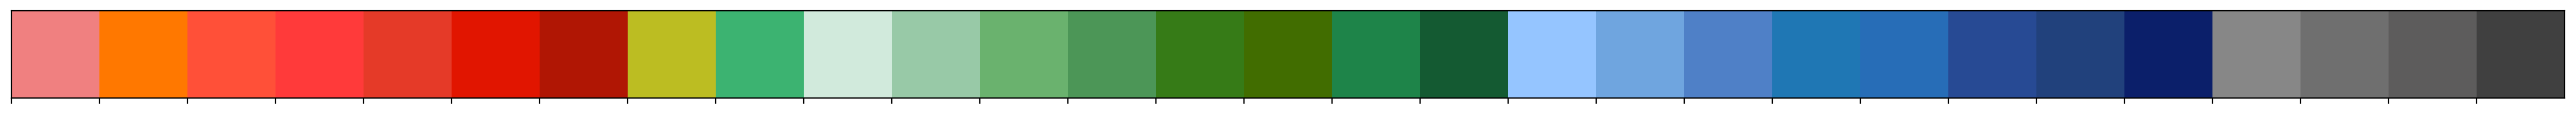

In [11]:
## colors
## colors - https://www.practicalpythonfordatascience.com/ap_seaborn_palette
color_scheme = ["#F08080", "#ff7800", "#ff5038", "#ff3a3a", "#e53a28", "#e11500", "#b01604", 
                "#BCBD22","#3CB371", "#d1eadc", "#98c9a7", "#6ab26e", "#4c9657", "#367b17", "#416d00", '#1e8449', '#145a32',
                "#95c5ff", "#6fa5df", "#4f80c7", "#1F77B4", "#276db7", '#274a94', '#21417c', '#0b1f6a',
                "#878787", "#6f6f6f", "#5d5c5c", "#404040"]

# Use list comprehension to select specific indices
selected_colors = [color_scheme[i] for i in [5, 20, 21]]
# Set your custom color palette
color_scheme_pal_three = sns.set_palette(sns.color_palette(selected_colors))

# Create a custom palette using HEX codes 
color_scheme_pal = sns.color_palette(color_scheme)
color_scheme_pal_two = [color_scheme_pal[0], color_scheme_pal[7]]
# color_scheme_pal_three = [color_scheme_pal[5], color_scheme_pal[20],color_scheme_pal[21]]

# sns.palplot(sns.color_palette(color_scheme_pal_two))
sns.palplot(sns.color_palette(color_scheme_pal))
# sns.palplot(sns.color_palette(color_scheme_pal_three))

<hr style="border:16px solid #404040">

### **Loading Data**

In [213]:
## Set paths
path_one = project_root + '/Data/Modified_Tables/consolidated_data_v1.csv.gz'

In [214]:
vent_model_data = pd.read_csv(path_one, compression='gzip')

<hr style="border:11px solid #404040">

The below sections perform EDA and table construction to obtain ventilator events for a sub-set of patients. 

<hr style="border:6px solid #404040">

<span style="color:#b01604;font-weight:700;font-size:22px"> 
Data Review
</span> <br>
- Review each incoming data table. 

In [215]:
## Ventilation Full Model Data
print(vent_model_data.shape)
vent_model_data.head(3)

(8461, 82)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,Vent_Dur_Min,Vent_Duration_Cat,LABEL,ADMISSION_TYPE,GENDER,Age_Admission,Resp_Diag_Label,50802_Base Excess,50804_Calculated Total CO2,50818_pCO2,50820_pH,50821_pO2,50868_Anion Gap,50882_Bicarbonate,50902_Chloride,50912_Creatinine,50931_Glucose,50960_Magnesium,50971_Potassium,50983_Sodium,51006_Urea Nitrogen,51221_Hematocrit,51222_Hemoglobin,51237_INR(PT),51248_MCH,51249_MCHC,51250_MCV,51265_Platelet Count,51274_PT,51275_PTT,51277_RDW,51279_Red Blood Cells,51301_White Blood Cells,220045_Heart Rate,220048_Heart Rhythm,220210_Respiratory Rate,220277_O2 saturation pulseoxymetry,220339_PEEP set,223781_Pain Present,223795_Pain Assessment Method,223835_Inspired O2 Fraction,223849_Ventilator Mode,223873_Paw High,223876_Apnea Interval,223900_GCS - Verbal Response,223901_GCS - Motor Response,223985_Respiratory Pattern,223986_RUL Lung Sounds,223987_RLL Lung Sounds,223988_LUL Lung Sounds,223989_LLL Lung Sounds,223990_Respiratory Effort,223999_Oral Cavity,224001_Diet Type,224003_Abdominal Assessment,224004_Bowel Sounds,224015_Urine Source,224026_Skin Integrity,224027_Skin Temperature,224028_Skin Color,224054_Braden Sensory Perception,224055_Braden Moisture,224056_Braden Activity,224057_Braden Mobility,224058_Braden Nutrition,224059_Braden Friction/Shear,224080_Head of Bed,224082_Turn,224084_Activity,224086_Activity Tolerance,224093_Position,224168_Parameters Checked,224641_Alarms On,224642_Temperature Site,224687_Minute Volume,224697_Mean Airway Pressure,224860_Skin Condition,226253_SpO2 Desat Limit,226512_Admission Weight (Kg)
0,36,165660,241249.0,5714.0,Sig_Over_Day,Invasive Ventilation,ELECTIVE,M,72.7,Non_Resp,0.0,28.0,50.0,7.33,59.0,13.0,25.0,106.0,1.0,124.0,1.9,4.2,140.0,19.0,42.2,14.4,1.2,28.7,34.1,84.0,224.0,14.2,28.0,14.6,5.01,15.6,94.0,SR (Sinus Rhythm),20.0,91.0,5.0,Yes,Patient Verbalized,100.0,CMV/ASSIST/AutoFlow,40.0,20.0,Oriented,Obeys Commands,Regular,Clear,Rhonchi,Clear,Rhonchi,Shallow,Teeth/Tissue WNL,NPO,Soft,Absent,Indwelling Urinary Catheter,Impaired,Warm,Normal for Race,Slight Impairment,Rarely Moist,Bedfast,Slight Limitations,Probably Inadequate,Potential Problem,90 Degrees,Back,Bedrest,Good,Supine,1.0,1.0,Axillary,11.0,10.0,Dry,85.0,106.2
1,124,138376,256064.0,28000.0,Sig_Over_Day,Invasive Ventilation,EMERGENCY,M,75.1,Resp_Related,-4.0,19.0,29.0,7.40,83.0,15.0,21.0,111.0,3.2,134.0,3.5,3.3,144.0,119.0,29.8,9.7,1.2,27.5,32.5,85.0,319.0,13.9,29.0,15.5,3.52,12.6,72.0,SR (Sinus Rhythm),20.0,100.0,5.0,No,Change in Vitals,60.0,CMV/ASSIST/AutoFlow,35.0,20.0,No Response,No response,Regular,Clear,Clear,Clear,Clear,Normal,Teeth/Tissue WNL,NPO,Soft,Hypoactive,Indwelling Urinary Catheter,Impaired,Warm,Normal for Race,Very Limited,Occasionally Moist,Bedfast,Very Limited,Probably Inadequate,Problem,30 Degrees,Side to Side,Bedrest,Good,Left Side,1.0,1.0,Oral,7.5,9.0,Dry,85.0,77.0
2,165,170252,247247.0,854.0,Mod_Under_Day,Non-invasive Ventilation,EMERGENCY,M,86.5,Resp_Related,0.0,28.0,48.0,7.35,161.0,13.0,28.0,108.0,1.9,192.0,2.4,3.7,145.0,34.0,44.3,14.5,1.0,30.7,32.7,94.0,131.0,10.7,26.5,13.4,4.72,8.3,73.0,SR (Sinus Rhythm),19.0,99.0,5.0,No,Patient Verbalized,50.0,CPAP/PSV,35.0,20.0,Oriented,Obeys Commands,Regular,Ins/Exp Wheeze,Insp/Exp Wheeze,Ins/Exp Wheeze,Diminished,Normal,Teeth/Tissue WNL,NPO,Firm Distended,Hypoactive,Indwelling Urinary Catheter,Intact,Warm,Normal for Race,Slight Impairment,Occasionally Moist,Bedfast,Very Limited,Probably Inadequate,Potential Problem,45 Degrees,Side to Side,Bedrest,Tolerated Well,Left Side,1.0,1.0,Axillary,3.8,7.0,Dry,88.0,70.0


In [216]:
### Reduce down to only the Y Numeric and X Values
vent_model_data_mod = vent_model_data.iloc[:, [3]].join(vent_model_data.iloc[:, 5:]).copy()

In [ ]:
vent_model_data_mod.loc[:,['223986_RUL Lung Sounds','223987_RLL Lung Sounds','223988_LUL Lung Sounds','223989_LLL Lung Sounds']]

----
### **Remove Select Features due to VIF Research**

In [210]:
remove_vif_list = ['50802_Base Excess','50902_Chloride','51221_Hematocrit','51237_INR(PT)','51248_MCH',
                   '51250_MCV','51274_PT','51279_Red Blood Cells','223988_LUL Lung Sounds','223989_LLL Lung Sounds']

In [217]:
## Drop Columns
vent_model_data_mod = vent_model_data_mod.drop(remove_vif_list, axis=1)

In [218]:
print(vent_model_data_mod.shape)
vent_model_data_mod.head(3)

(8461, 68)


,Vent_Dur_Min,LABEL,ADMISSION_TYPE,GENDER,Age_Admission,Resp_Diag_Label,50804_Calculated Total CO2,50818_pCO2,50820_pH,50821_pO2,50868_Anion Gap,50882_Bicarbonate,50912_Creatinine,50931_Glucose,50960_Magnesium,50971_Potassium,50983_Sodium,51006_Urea Nitrogen,51222_Hemoglobin,51249_MCHC,51265_Platelet Count,51275_PTT,51277_RDW,51301_White Blood Cells,220045_Heart Rate,220048_Heart Rhythm,220210_Respiratory Rate,220277_O2 saturation pulseoxymetry,220339_PEEP set,223781_Pain Present,223795_Pain Assessment Method,223835_Inspired O2 Fraction,223849_Ventilator Mode,223873_Paw High,223876_Apnea Interval,223900_GCS - Verbal Response,223901_GCS - Motor Response,223985_Respiratory Pattern,223986_RUL Lung Sounds,223987_RLL Lung Sounds,223990_Respiratory Effort,223999_Oral Cavity,224001_Diet Type,224003_Abdominal Assessment,224004_Bowel Sounds,224015_Urine Source,224026_Skin Integrity,224027_Skin Temperature,224028_Skin Color,224054_Braden Sensory Perception,224055_Braden Moisture,224056_Braden Activity,224057_Braden Mobility,224058_Braden Nutrition,224059_Braden Friction/Shear,224080_Head of Bed,224082_Turn,224084_Activity,224086_Activity Tolerance,224093_Position,224168_Parameters Checked,224641_Alarms On,224642_Temperature Site,224687_Minute Volume,224697_Mean Airway Pressure,224860_Skin Condition,226253_SpO2 Desat Limit,226512_Admission Weight (Kg)
0,5714.0,Invasive Ventilation,ELECTIVE,M,72.7,Non_Resp,28.0,50.0,7.33,59.0,13.0,25.0,1.0,124.0,1.9,4.2,140.0,19.0,14.4,34.1,224.0,28.0,14.6,15.6,94.0,SR (Sinus Rhythm),20.0,91.0,5.0,Yes,Patient Verbalized,100.0,CMV/ASSIST/AutoFlow,40.0,20.0,Oriented,Obeys Commands,Regular,Clear,Rhonchi,Shallow,Teeth/Tissue WNL,NPO,Soft,Absent,Indwelling Urinary Catheter,Impaired,Warm,Normal for Race,Slight Impairment,Rarely Moist,Bedfast,Slight Limitations,Probably Inadequate,Potential Problem,90 Degrees,Back,Bedrest,Good,Supine,1.0,1.0,Axillary,11.0,10.0,Dry,85.0,106.2
1,28000.0,Invasive Ventilation,EMERGENCY,M,75.1,Resp_Related,19.0,29.0,7.40,83.0,15.0,21.0,3.2,134.0,3.5,3.3,144.0,119.0,9.7,32.5,319.0,29.0,15.5,12.6,72.0,SR (Sinus Rhythm),20.0,100.0,5.0,No,Change in Vitals,60.0,CMV/ASSIST/AutoFlow,35.0,20.0,No Response,No response,Regular,Clear,Clear,Normal,Teeth/Tissue WNL,NPO,Soft,Hypoactive,Indwelling Urinary Catheter,Impaired,Warm,Normal for Race,Very Limited,Occasionally Moist,Bedfast,Very Limited,Probably Inadequate,Problem,30 Degrees,Side to Side,Bedrest,Good,Left Side,1.0,1.0,Oral,7.5,9.0,Dry,85.0,77.0
2,854.0,Non-invasive Ventilation,EMERGENCY,M,86.5,Resp_Related,28.0,48.0,7.35,161.0,13.0,28.0,1.9,192.0,2.4,3.7,145.0,34.0,14.5,32.7,131.0,26.5,13.4,8.3,73.0,SR (Sinus Rhythm),19.0,99.0,5.0,No,Patient Verbalized,50.0,CPAP/PSV,35.0,20.0,Oriented,Obeys Commands,Regular,Ins/Exp Wheeze,Insp/Exp Wheeze,Normal,Teeth/Tissue WNL,NPO,Firm Distended,Hypoactive,Indwelling Urinary Catheter,Intact,Warm,Normal for Race,Slight Impairment,Occasionally Moist,Bedfast,Very Limited,Probably Inadequate,Potential Problem,45 Degrees,Side to Side,Bedrest,Tolerated Well,Left Side,1.0,1.0,Axillary,3.8,7.0,Dry,88.0,70.0


----
### **Scale Numerical Features**

In [219]:
### Determine Columns that are Strings / Objects
numeric_cols = vent_model_data_mod.select_dtypes(include=[np.number]).columns

# Initialize scaler
scaler = StandardScaler()

# Fit and transform only the numeric columns
vent_model_data_mod[numeric_cols] = scaler.fit_transform(vent_model_data_mod[numeric_cols])

In [220]:
vent_model_data_mod.head(3)

,Vent_Dur_Min,LABEL,ADMISSION_TYPE,GENDER,Age_Admission,Resp_Diag_Label,50804_Calculated Total CO2,50818_pCO2,50820_pH,50821_pO2,50868_Anion Gap,50882_Bicarbonate,50912_Creatinine,50931_Glucose,50960_Magnesium,50971_Potassium,50983_Sodium,51006_Urea Nitrogen,51222_Hemoglobin,51249_MCHC,51265_Platelet Count,51275_PTT,51277_RDW,51301_White Blood Cells,220045_Heart Rate,220048_Heart Rhythm,220210_Respiratory Rate,220277_O2 saturation pulseoxymetry,220339_PEEP set,223781_Pain Present,223795_Pain Assessment Method,223835_Inspired O2 Fraction,223849_Ventilator Mode,223873_Paw High,223876_Apnea Interval,223900_GCS - Verbal Response,223901_GCS - Motor Response,223985_Respiratory Pattern,223986_RUL Lung Sounds,223987_RLL Lung Sounds,223990_Respiratory Effort,223999_Oral Cavity,224001_Diet Type,224003_Abdominal Assessment,224004_Bowel Sounds,224015_Urine Source,224026_Skin Integrity,224027_Skin Temperature,224028_Skin Color,224054_Braden Sensory Perception,224055_Braden Moisture,224056_Braden Activity,224057_Braden Mobility,224058_Braden Nutrition,224059_Braden Friction/Shear,224080_Head of Bed,224082_Turn,224084_Activity,224086_Activity Tolerance,224093_Position,224168_Parameters Checked,224641_Alarms On,224642_Temperature Site,224687_Minute Volume,224697_Mean Airway Pressure,224860_Skin Condition,226253_SpO2 Desat Limit,226512_Admission Weight (Kg)
0,0.221160,Invasive Ventilation,ELECTIVE,M,0.504924,Non_Resp,0.367191,0.447701,-0.340389,-1.177439,-0.349229,0.111490,-0.285989,-0.272788,-0.188265,-0.109374,0.295044,-0.354147,1.241199,0.364483,-0.094502,-0.334068,-0.135559,0.463585,0.310830,SR (Sinus Rhythm),0.375663,-1.503442,-0.332637,Yes,Patient Verbalized,0.859254,CMV/ASSIST/AutoFlow,-0.047838,-0.124985,Oriented,Obeys Commands,Regular,Clear,Rhonchi,Shallow,Teeth/Tissue WNL,NPO,Soft,Absent,Indwelling Urinary Catheter,Impaired,Warm,Normal for Race,Slight Impairment,Rarely Moist,Bedfast,Slight Limitations,Probably Inadequate,Potential Problem,90 Degrees,Back,Bedrest,Good,Supine,0.034399,0.03608,Axillary,0.140441,0.135256,Dry,-0.343109,0.909220
1,3.398869,Invasive Ventilation,EMERGENCY,M,0.654193,Resp_Related,-1.212271,-1.091510,0.324175,-1.012322,0.109204,-0.689118,1.326446,-0.144451,3.680363,-1.228681,1.112588,4.510748,-0.791039,-0.604248,0.716613,-0.286029,0.311833,0.098235,-0.829488,SR (Sinus Rhythm),0.375663,0.517130,-0.332637,No,Change in Vitals,-0.701843,CMV/ASSIST/AutoFlow,-1.061249,-0.124985,No Response,No response,Regular,Clear,Clear,Normal,Teeth/Tissue WNL,NPO,Soft,Hypoactive,Indwelling Urinary Catheter,Impaired,Warm,Normal for Race,Very Limited,Occasionally Moist,Bedfast,Very Limited,Probably Inadequate,Problem,30 Degrees,Side to Side,Bedrest,Good,Left Side,0.034399,0.03608,Oral,-0.139842,-0.136250,Dry,-0.343109,-0.258089
2,-0.471816,Non-invasive Ventilation,EMERGENCY,M,1.363223,Resp_Related,0.367191,0.301109,-0.150513,-0.475693,-0.349229,0.711946,0.373644,0.599907,1.020682,-0.731211,1.316973,0.375588,1.284438,-0.483156,-0.888541,-0.406127,-0.732081,-0.425433,-0.777655,SR (Sinus Rhythm),0.215465,0.292622,-0.332637,No,Patient Verbalized,-1.092118,CPAP/PSV,-1.061249,-0.124985,Oriented,Obeys Commands,Regular,Ins/Exp Wheeze,Insp/Exp Wheeze,Normal,Teeth/Tissue WNL,NPO,Firm Distended,Hypoactive,Indwelling Urinary Catheter,Intact,Warm,Normal for Race,Slight Impairment,Occasionally Moist,Bedfast,Very Limited,Probably Inadequate,Potential Problem,45 Degrees,Side to Side,Bedrest,Tolerated Well,Left Side,0.034399,0.03608,Axillary,-0.436142,-0.679262,Dry,1.526766,-0.537923


-----
### **Based on VIF - Remove Certain Features**

In [221]:
vent_model_data_mod.columns

Index(['Vent_Dur_Min', 'LABEL', 'ADMISSION_TYPE', 'GENDER', 'Age_Admission',
       'Resp_Diag_Label', '50804_Calculated Total CO2', '50818_pCO2',
       '50820_pH', '50821_pO2', '50868_Anion Gap', '50882_Bicarbonate',
       '50912_Creatinine', '50931_Glucose', '50960_Magnesium',
       '50971_Potassium', '50983_Sodium', '51006_Urea Nitrogen',
       '51222_Hemoglobin', '51249_MCHC', '51265_Platelet Count', '51275_PTT',
       '51277_RDW', '51301_White Blood Cells', '220045_Heart Rate',
       '220048_Heart Rhythm', '220210_Respiratory Rate',
       '220277_O2 saturation pulseoxymetry', '220339_PEEP set',
       '223781_Pain Present', '223795_Pain Assessment Method',
       '223835_Inspired O2 Fraction', '223849_Ventilator Mode',
       '223873_Paw High', '223876_Apnea Interval',
       '223900_GCS - Verbal Response', '223901_GCS - Motor Response',
       '223985_Respiratory Pattern', '223986_RUL Lung Sounds',
       '223987_RLL Lung Sounds', '223990_Respiratory Effort',
       '22399

#### **String Based Features**

In [223]:
object_columns = vent_model_data_mod.select_dtypes(include=['object']).columns.tolist()
print(len(object_columns))
print(object_columns)

35
['LABEL', 'ADMISSION_TYPE', 'GENDER', 'Resp_Diag_Label', '220048_Heart Rhythm', '223781_Pain Present', '223795_Pain Assessment Method', '223849_Ventilator Mode', '223900_GCS - Verbal Response', '223901_GCS - Motor Response', '223985_Respiratory Pattern', '223986_RUL Lung Sounds', '223987_RLL Lung Sounds', '223990_Respiratory Effort', '223999_Oral Cavity', '224001_Diet Type', '224003_Abdominal Assessment', '224004_Bowel Sounds', '224015_Urine Source', '224026_Skin Integrity', '224027_Skin Temperature', '224028_Skin Color', '224054_Braden Sensory Perception', '224055_Braden Moisture', '224056_Braden Activity', '224057_Braden Mobility', '224058_Braden Nutrition', '224059_Braden Friction/Shear', '224080_Head of Bed', '224082_Turn', '224084_Activity', '224086_Activity Tolerance', '224093_Position', '224642_Temperature Site', '224860_Skin Condition']


<hr style="border:20px solid #404040">

## **Regression**

In [224]:
# Activate automatic conversion between pandas/numpy and R dataframes/vectors
rpy2.robjects.pandas2ri.activate()
rpy2.robjects.numpy2ri.activate()

In [225]:
vent_model_data_mod.head(2)

,Vent_Dur_Min,LABEL,ADMISSION_TYPE,GENDER,Age_Admission,Resp_Diag_Label,50804_Calculated Total CO2,50818_pCO2,50820_pH,50821_pO2,50868_Anion Gap,50882_Bicarbonate,50912_Creatinine,50931_Glucose,50960_Magnesium,50971_Potassium,50983_Sodium,51006_Urea Nitrogen,51222_Hemoglobin,51249_MCHC,51265_Platelet Count,51275_PTT,51277_RDW,51301_White Blood Cells,220045_Heart Rate,220048_Heart Rhythm,220210_Respiratory Rate,220277_O2 saturation pulseoxymetry,220339_PEEP set,223781_Pain Present,223795_Pain Assessment Method,223835_Inspired O2 Fraction,223849_Ventilator Mode,223873_Paw High,223876_Apnea Interval,223900_GCS - Verbal Response,223901_GCS - Motor Response,223985_Respiratory Pattern,223986_RUL Lung Sounds,223987_RLL Lung Sounds,223990_Respiratory Effort,223999_Oral Cavity,224001_Diet Type,224003_Abdominal Assessment,224004_Bowel Sounds,224015_Urine Source,224026_Skin Integrity,224027_Skin Temperature,224028_Skin Color,224054_Braden Sensory Perception,224055_Braden Moisture,224056_Braden Activity,224057_Braden Mobility,224058_Braden Nutrition,224059_Braden Friction/Shear,224080_Head of Bed,224082_Turn,224084_Activity,224086_Activity Tolerance,224093_Position,224168_Parameters Checked,224641_Alarms On,224642_Temperature Site,224687_Minute Volume,224697_Mean Airway Pressure,224860_Skin Condition,226253_SpO2 Desat Limit,226512_Admission Weight (Kg)
0,0.221160,Invasive Ventilation,ELECTIVE,M,0.504924,Non_Resp,0.367191,0.447701,-0.340389,-1.177439,-0.349229,0.111490,-0.285989,-0.272788,-0.188265,-0.109374,0.295044,-0.354147,1.241199,0.364483,-0.094502,-0.334068,-0.135559,0.463585,0.310830,SR (Sinus Rhythm),0.375663,-1.503442,-0.332637,Yes,Patient Verbalized,0.859254,CMV/ASSIST/AutoFlow,-0.047838,-0.124985,Oriented,Obeys Commands,Regular,Clear,Rhonchi,Shallow,Teeth/Tissue WNL,NPO,Soft,Absent,Indwelling Urinary Catheter,Impaired,Warm,Normal for Race,Slight Impairment,Rarely Moist,Bedfast,Slight Limitations,Probably Inadequate,Potential Problem,90 Degrees,Back,Bedrest,Good,Supine,0.034399,0.03608,Axillary,0.140441,0.135256,Dry,-0.343109,0.909220
1,3.398869,Invasive Ventilation,EMERGENCY,M,0.654193,Resp_Related,-1.212271,-1.091510,0.324175,-1.012322,0.109204,-0.689118,1.326446,-0.144451,3.680363,-1.228681,1.112588,4.510748,-0.791039,-0.604248,0.716613,-0.286029,0.311833,0.098235,-0.829488,SR (Sinus Rhythm),0.375663,0.517130,-0.332637,No,Change in Vitals,-0.701843,CMV/ASSIST/AutoFlow,-1.061249,-0.124985,No Response,No response,Regular,Clear,Clear,Normal,Teeth/Tissue WNL,NPO,Soft,Hypoactive,Indwelling Urinary Catheter,Impaired,Warm,Normal for Race,Very Limited,Occasionally Moist,Bedfast,Very Limited,Probably Inadequate,Problem,30 Degrees,Side to Side,Bedrest,Good,Left Side,0.034399,0.03608,Oral,-0.139842,-0.136250,Dry,-0.343109,-0.258089


In [226]:
# Convert Pandas DataFrame to R DataFrame
r_vent_model_data = rpy2.robjects.pandas2ri.py2rpy(vent_model_data_mod)

In [227]:
# print(dim(whz_scores_r_mo_0))
print(robjects.r['dim'](r_vent_model_data))
r_vent_model_data.head()

[1] 8461   68



,,Vent_Dur_Min,LABEL,ADMISSION_TYPE,GENDER,...,226253_SpO2 Desat Limit,226512_Admission Weight (Kg)
0,0,0.2211599994329588,Invasive Ventilation,ELECTIVE,M,...,-0.3431088095451167,0.9092195168345457
1,1,3.398868833201717,Invasive Ventilation,EMERGENCY,M,...,-0.3431088095451167,-0.25808891042182375
2,2,-0.47181608116096413,Non-invasive Ventilation,EMERGENCY,M,...,1.5267664293512626,-0.537923122435337
3,3,-0.2084566530010926,Invasive Ventilation,EMERGENCY,M,...,-0.3431088095451167,-0.12216943601525997
4,4,0.7802462570479324,Invasive Ventilation,EMERGENCY,M,...,-0.3431088095451167,-0.1581481204169976
5,5,-0.2556531720703495,Invasive Ventilation,EMERGENCY,M,...,-0.3431088095451167,-0.018231014410241


In [228]:
print(robjects.r['str'](r_vent_model_data))

'data.frame':	8461 obs. of  68 variables:
 $ Vent_Dur_Min                      : num  0.221 3.399 -0.472 -0.208 0.78 ...
 $ LABEL                             : chr  "Invasive Ventilation" "Invasive Ventilation" "Non-invasive Ventilation" "Invasive Ventilation" ...
 $ ADMISSION_TYPE                    : chr  "ELECTIVE" "EMERGENCY" "EMERGENCY" "EMERGENCY" ...
 $ GENDER                            : chr  "M" "M" "M" "M" ...
 $ Age_Admission                     : num  0.505 0.654 1.363 -0.559 -0.503 ...
 $ Resp_Diag_Label                   : chr  "Non_Resp" "Resp_Related" "Resp_Related" "Non_Resp" ...
 $ 50804_Calculated Total CO2        : num  0.3672 -1.2123 0.3672 -1.7388 0.0162 ...
 $ 50818_pCO2                        : num  0.4477 -1.09151 0.30111 -0.72503 0.00793 ...
 $ 50820_pH                          : num  -0.3404 0.3242 -0.1505 -1.005 0.0394 ...
 $ 50821_pO2                         : num  -1.177 -1.012 -0.476 -0.393 -0.627 ...
 $ 50868_Anion Gap                   : num  -0.349 0.1

<hr style="border:5px solid #315376">

In [229]:
print(object_columns)

['LABEL', 'ADMISSION_TYPE', 'GENDER', 'Resp_Diag_Label', '220048_Heart Rhythm', '223781_Pain Present', '223795_Pain Assessment Method', '223849_Ventilator Mode', '223900_GCS - Verbal Response', '223901_GCS - Motor Response', '223985_Respiratory Pattern', '223986_RUL Lung Sounds', '223987_RLL Lung Sounds', '223990_Respiratory Effort', '223999_Oral Cavity', '224001_Diet Type', '224003_Abdominal Assessment', '224004_Bowel Sounds', '224015_Urine Source', '224026_Skin Integrity', '224027_Skin Temperature', '224028_Skin Color', '224054_Braden Sensory Perception', '224055_Braden Moisture', '224056_Braden Activity', '224057_Braden Mobility', '224058_Braden Nutrition', '224059_Braden Friction/Shear', '224080_Head of Bed', '224082_Turn', '224084_Activity', '224086_Activity Tolerance', '224093_Position', '224642_Temperature Site', '224860_Skin Condition']


In [230]:
## Factor - Convert each specified column to factor using index assignment
as_factor = robjects.r('as.factor')
factor_cols=object_columns
for col in factor_cols:
    col_index = list(r_vent_model_data.names).index(col)
    r_vent_model_data[col_index] = as_factor(r_vent_model_data.rx2[col])

---
### **Run Multi-Variate LM Mother's Stature**

In [231]:
# ## Set df in the global env. with the name data.
robjects.globalenv['data'] = r_vent_model_data

In [232]:
# Run the linear regression model in R: lm(y ~ x)
vent_reg_model = stats.lm("Vent_Dur_Min ~ .", data=r_vent_model_data)
robjects.globalenv["vent_reg_model"] = vent_reg_model # You need to assign to R's global environment

In [233]:
# Get the summary data of the linear model
summary_data = robjects.r["summary"](vent_reg_model)

In [234]:
print(vent_reg_model.names)
print("")
print(summary_data.names)

['coefficients' 'residuals' 'effects' 'rank' 'fitted.values' 'assign' 'qr'
 'df.residual' 'contrasts' 'xlevels' 'call' 'terms' 'model']

['call' 'terms' 'residuals' 'coefficients' 'aliased' 'sigma' 'df'
 'r.squared' 'adj.r.squared' 'fstatistic' 'cov.unscaled']


In [176]:
# summary_data

In [177]:
## Show the R regression summary (Warning - will show the entire run plus results), use Helper below. 
# print(summary_data)

In [236]:
# Use helper to review Residuals. 
print(print_residual(summary_data))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2851 -0.4185 -0.1564  0.1223 17.8543 

Coefficients:
                                                                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                                                                     -0.5631179  0.9771325  -0.576 0.564431    
LABELNon-invasive Ventilation                                                   -0.7705841  0.0627314 -12.284  < 2e-16 ***
ADMISSION_TYPEEMERGENCY                                                          0.1195391  0.0315789   3.785 0.000155 ***
ADMISSION_TYPEURGENT                                                             0.1182767  0.0923401   1.281 0.200271    
GENDERM                                                                         -0.0451942  0.0233797  -1.933 0.053264 .  
Age_Admission                                                                    0.0089584  0.0123579   0.725 0.468524    
Resp_Diag_LabelResp_Related    

In [237]:
## Print Summary Table with CIs
result = lm_summary_ci(vent_reg_model)
print(f" Degrees of freedom: {result[1]} ")

lm_summary_ci(vent_reg_model)[0]

 Degrees of freedom: 8215 


,Variable,Coeff_Value,Std_Error,T_Value,P_Value,CI_Lower,CI_Higher
0,(Intercept),-0.563118,0.977133,-0.576296,5.644307e-01,-2.478545,1.352309
1,LABELNon-invasive Ventilation,-0.770584,0.062731,-12.283865,2.212742e-34,-0.893554,-0.647615
2,ADMISSION_TYPEEMERGENCY,0.119539,0.031579,3.785406,1.545504e-04,0.057636,0.181442
3,ADMISSION_TYPEURGENT,0.118277,0.092340,1.280882,2.002713e-01,-0.062733,0.299287
4,GENDERM,-0.045194,0.023380,-1.933054,5.326388e-02,-0.091024,0.000636
...,...,...,...,...,...,...,...
241,`224697_Mean Airway Pressure`,0.066781,0.012923,5.167548,2.427644e-07,0.041448,0.092113
242,`224860_Skin Condition`Diaphoretic,0.146981,0.127652,1.151415,2.495949e-01,-0.103250,0.397212
243,`224860_Skin Condition`Dry,0.038157,0.104868,0.363855,7.159755e-01,-0.167411,0.243725
244,`226253_SpO2 Desat Limit`,-0.000670,0.010547,-0.063494,9.493743e-01,-0.021345,0.020006


In [238]:
reg_coeff_results = lm_summary_ci(vent_reg_model)[0]
reg_coeff_results.head(1)

,Variable,Coeff_Value,Std_Error,T_Value,P_Value,CI_Lower,CI_Higher
0,(Intercept),-0.563118,0.977133,-0.576296,0.564431,-2.478545,1.352309


### **Save Down**

In [239]:
# Save the combined DataFrame to a CSV or Excel file
csv_naming = 'regression_coeff_conf_int_7_15'; csv_naming = csv_naming + '.csv'  ## naming, two lines of code
# X_final.to_csv(csv_naming, index=False, compression='gzip')
reg_coeff_results.to_csv(csv_naming, index=False)
print(f"All files processed and saved to {csv_naming}")

All files processed and saved to regression_coeff_conf_int_7_15.csv


<hr style="border:15px solid #315376">

# **Multicolinearity [VIF]**

------
## Cars VIF
- Because several of the categories have multiple lables, we need Generalized VIF, which R Car is capable of. 

---
### **Determine Aliases**

In [242]:
alias_df

,(Intercept),LABELNon-invasive Ventilation,ADMISSION_TYPEEMERGENCY,ADMISSION_TYPEURGENT,GENDERM,Age_Admission,Resp_Diag_LabelResp_Related,`50802_Base Excess`,`50804_Calculated Total CO2`,`50818_pCO2`,`50820_pH`,`50821_pO2`,`50868_Anion Gap`,`50882_Bicarbonate`,`50902_Chloride`,`50912_Creatinine`,`50931_Glucose`,`50960_Magnesium`,`50971_Potassium`,`50983_Sodium`,`51006_Urea Nitrogen`,`51221_Hematocrit`,`51222_Hemoglobin`,`51237_INR(PT)`,`51248_MCH`,`51249_MCHC`,`51250_MCV`,`51265_Platelet Count`,`51274_PT`,`51275_PTT`,`51277_RDW`,`51279_Red Blood Cells`,`51301_White Blood Cells`,`220045_Heart Rate`,`220048_Heart Rhythm`2nd AV M2 (Second degree AV Block - Mobitz 2),`220048_Heart Rhythm`2nd AV W-M1 (Second degree AV Block Wenckebach - Mobitz1),`220048_Heart Rhythm`3rd AV (Complete Heart Block),`220048_Heart Rhythm`A Flut (Atrial Flutter),`220048_Heart Rhythm`A Paced,`220048_Heart Rhythm`AF (Atrial Fibrillation),`220048_Heart Rhythm`Asystole,`220048_Heart Rhythm`AV Paced,`220048_Heart Rhythm`Idioventricular,`220048_Heart Rhythm`JR (Junctional Rhythm),`220048_Heart Rhythm`JT (Junctional Tachycardia),`220048_Heart Rhythm`LBBB (Left Bundle Branch Block),`220048_Heart Rhythm`MAT (Multifocal atrial tachycardia),`220048_Heart Rhythm`PAT (Paroxysmal Atrial Tachycardia),`220048_Heart Rhythm`RBBB (Right Bundle Branch Block),`220048_Heart Rhythm`SA (Sinus Arrhythmia),`220048_Heart Rhythm`SB (Sinus Bradycardia),`220048_Heart Rhythm`SR (Sinus Rhythm),`220048_Heart Rhythm`ST (Sinus Tachycardia),`220048_Heart Rhythm`SVT (Supra Ventricular Tachycardia),`220048_Heart Rhythm`V Paced,`220048_Heart Rhythm`VF (Ventricular Fibrillation),`220048_Heart Rhythm`VT (Ventricular Tachycardia),`220048_Heart Rhythm`WAP (Wandering atrial pacemaker),`220210_Respiratory Rate`,`220277_O2 saturation pulseoxymetry`,`220339_PEEP set`,`223781_Pain Present`Yes,`223795_Pain Assessment Method`FLACC,`223795_Pain Assessment Method`Grimace Scale,`223795_Pain Assessment Method`Non-verbal Cues,`223795_Pain Assessment Method`Not applicable,`223795_Pain Assessment Method`PAINAD,`223795_Pain Assessment Method`Patient Verbalized,`223795_Pain Assessment Method`Wong-Baker Scale,`223835_Inspired O2 Fraction`,`223849_Ventilator Mode`CMV,`223849_Ventilator Mode`CMV/ASSIST,`223849_Ventilator Mode`CMV/ASSIST/AutoFlow,`223849_Ventilator Mode`CMV/AutoFlow,`223849_Ventilator Mode`CPAP,`223849_Ventilator Mode`CPAP/PPS,`223849_Ventilator Mode`CPAP/PSV,`223849_Ventilator Mode`CPAP/PSV+Apn TCPL,`223849_Ventilator Mode`CPAP/PSV+ApnPres,`223849_Ventilator Mode`CPAP/PSV+ApnVol,`223849_Ventilator Mode`MMV/PSV,`223849_Ventilator Mode`MMV/PSV/AutoFlow,`223849_Ventilator Mode`PCV+,`223849_Ventilator Mode`PCV+/PSV,`223849_Ventilator Mode`PCV+Assist,`223849_Ventilator Mode`PRES/AC,`223849_Ventilator Mode`PRVC/AC,`223849_Ventilator Mode`PRVC/SIMV,`223849_Ventilator Mode`PSV/SBT,`223849_Ventilator Mode`SIMV,`223849_Ventilator Mode`SIMV/AutoFlow,`223849_Ventilator Mode`SIMV/PRES,`223849_Ventilator Mode`SIMV/PSV,`223849_Ventilator Mode`SIMV/PSV/AutoFlow,`223849_Ventilator Mode`SIMV/VOL,`223849_Ventilator Mode`Standby,`223849_Ventilator Mode`VOL/AC,`223873_Paw High`,`223876_Apnea Interval`,`223900_GCS - Verbal Response`Inappropriate Words,`223900_GCS - Verbal Response`Incomprehensible sounds,`223900_GCS - Verbal Response`No Response,`223900_GCS - Verbal Response`No Response-ETT,`223900_GCS - Verbal Response`Oriented,`223901_GCS - Motor Response`Abnormal Flexion,`223901_GCS - Motor Response`Flex-withdraws,`223901_GCS - Motor Response`Localizes Pain,`223901_GCS - Motor Response`No response,`223901_GCS - Motor Response`Obeys Commands,`223985_Respiratory Pattern`Cheyne-Stokes,`223985_Respiratory Pattern`Discoordinate,`223985_Respiratory Pattern`Irregular,`223985_Respiratory Pattern`Kussmaul,`223985_Respiratory Pattern`Regular,`223985_Respiratory Pattern`Tachypneic,`223986_RUL Lung Sounds`Bronchial,`223986_RUL Lung Sounds`Clear,`223986_RUL Lung Sounds`Crackles,`223986_RUL Lung Sounds`Diminished,`223986_RUL Lung 

In [187]:
# Variables that are perfectly explained by others (non-zero rows)
aliased_vars = alias_df.index[alias_df.abs().sum(axis=1) > 0].tolist()
aliased_vars

['`223988_LUL Lung Sounds`Stridor',
 '`223989_LLL Lung Sounds`Stridor',
 '`223989_LLL Lung Sounds`Tubular']

----
### **Run VIF**

In [243]:
# xxx is created in Python via stats.lm()
# You need to assign it to R's global environment manually:
robjects.globalenv["vent_reg_model"] = vent_reg_model

# Now you can safely run vif() and convert to data.frame
r('vif_df <- as.data.frame(vif(vent_reg_model))')

# Convert to pandas DataFrame
vif_df = robjects.pandas2ri.rpy2py(r['vif_df'])
vif_df.index.name = 'variable'
vif_df.reset_index(inplace=True)

print(vif_df)

                          variable      GVIF   Df  GVIF^(1/(2*Df))
0                            LABEL  1.623725  1.0         1.274255
1                   ADMISSION_TYPE  1.719031  2.0         1.145041
2                           GENDER  1.315014  1.0         1.146741
3                    Age_Admission  1.534573  1.0         1.238779
4                  Resp_Diag_Label  1.265385  1.0         1.124893
..                             ...       ...  ...              ...
62          `224687_Minute Volume`  1.036781  1.0         1.018224
63   `224697_Mean Airway Pressure`  1.678158  1.0         1.295437
64         `224860_Skin Condition`  1.314579  2.0         1.070771
65       `226253_SpO2 Desat Limit`  1.117840  1.0         1.057280
66  `226512_Admission Weight (Kg)`  1.749122  1.0         1.322544

[67 rows x 4 columns]


In [244]:
vif_df

,variable,GVIF,Df,GVIF^(1/(2*Df))
0,LABEL,1.623725,1.0,1.274255
1,ADMISSION_TYPE,1.719031,2.0,1.145041
2,GENDER,1.315014,1.0,1.146741
3,Age_Admission,1.534573,1.0,1.238779
4,Resp_Diag_Label,1.265385,1.0,1.124893
...,...,...,...,...
62,`224687_Minute Volume`,1.036781,1.0,1.018224
63,`224697_Mean Airway Pressure`,1.678158,1.0,1.295437
64,`224860_Skin Condition`,1.314579,2.0,1.070771
65,`226253_SpO2 Desat Limit`,1.117840,1.0,1.057280


In [245]:
# Save the combined DataFrame to a CSV or Excel file
csv_naming = 'vif_results_7_15'; csv_naming = csv_naming + '.csv'  ## naming, two lines of code
# X_final.to_csv(csv_naming, index=False, compression='gzip')
vif_df.to_csv(csv_naming, index=False)
print(f"All files processed and saved to {csv_naming}")

All files processed and saved to vif_results_7_15.csv
